# Cycle-consistency Learning


## Setup

In [0]:
from google.colab import drive
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

import json 


drive.mount('/content/Drive', force_remount=True)
os.chdir('/content/Drive/My Drive/Projet 3A : PIR/')
print(os.getcwd())
print(*os.listdir(),sep=",")

print('Test d\'acces aux données:',end=" ")
print(len(os.listdir("Data/annotations/")) > 0 ,end=", ")
print(len(os.listdir("Data/unlabeled2017/")) > 0,end="\n")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/Drive
/content/Drive/My Drive/Projet 3A : PIR
weights,Data,poster,output,__pycache__,image_autoencoding.ipynb,text_autoencoder.ipynb,m_text.py,utils.py,m_image.py,combined_learning.ipynb
Test d'acces aux données: True, 

OSError: ignored

In [0]:
l=0
e=1
while l == 0 and e < 100:
  try :
    l=len(os.listdir("Data/unlabeled2017/"))
  except:
    e+=1
    print(".",end="")
    if e%10 ==0 : 
      print("")
      
    pass
print("\n Monted in {} steps".format(e))

.........
..........
..........
..........
..........
..........
..........
.........
 Monted in 79 steps


## Preprocessing of the inputs



### Loading Data


In [0]:
file_name="Data/annotations/dataset_coco.json" #dataset_flickr30k.json"
json_file=json.load(open(file_name))


split={'restval':0, 'test':0, 'train': 0, 'val': 0}
text_validation_set=[]
text_training_set=[]

for image in json_file["images"]:
  for i in range(len(image["sentids"])):
    tokens=list(map(lambda x: x.strip('(').strip(')'), image["sentences"][i]["tokens"]) )
    #lst.append(tokens)
    if image['split'] == "test":
      text_validation_set.append( tokens)
    else :
      text_training_set.append(tokens)
    split[image['split']]+=1
    
    
np.random.shuffle(text_validation_set)
np.random.shuffle(text_training_set)


size=len(text_validation_set)+len(text_training_set)
men_size=np.mean([len(tmp) for tmp in text_training_set] )
var_size=np.std([len(tmp) for tmp in text_training_set] )


print('Using {} sentences of mean length {} \pm {} with the following repartition :'.format(size,men_size,var_size))
for key in split.keys():
      print( "\t{} : {}".format(key,split[key]))




Using 616767 sentences of mean length 10.465468089097383 \pm 2.3983184308093732 with the following repartition :
	restval : 152634
	test : 25010
	train : 414113
	val : 25010


In [0]:
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
%matplotlib inline


path="Data/unlabeled2017/"


file=open("Data/unlabled_list.txt")
lst = [ligne.strip('\n') for ligne in file]

size = len(lst)
np.random.shuffle(lst)

num_examples = 90000
img_training_set = lst[0:num_examples]
img_validation_set = lst[90000:(90000+2500)]

print('Using {} pictures (train: {}, val: {})'.format(size,num_examples,len(img_validation_set)) )



Using 99339 pictures (train: 90000, val: 2500)


### Loading Glove


In [0]:
!pip install glove_python

    100% |████████████████████████████████| 266kB 14.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


In [0]:
from glove import Corpus, Glove
from utils import create_embedding

glove=Glove.load_stanford("weights/glove.6B.100d.txt")
sub_glove=Glove.load("weights/sub_glove.10k.100d.txt")


### Loading Generator

In [0]:
import os.path
from utils import TextSequence,ImageSequence
      
text_training_sequence=TextSequence(sentences=text_training_set,glove=sub_glove,input_dim=10000, max_len=20)
text_validation_sequence=TextSequence(sentences=text_validation_set,glove=sub_glove,input_dim=10000, max_len=20)  

img_training_sequence=ImageSequence(path="Data/unlabeled2017/",img_db=img_training_set)
img_validation_sequence=ImageSequence(path="Data/unlabeled2017/",img_db=img_validation_set)

### Loading Models and weights

In [0]:
import m_image as image

input_shape=(64,64,3)
latent_dim=1024
reshape_shape=(8,8,256)
number_of_block=3


config=dict()
config["vgg_loss"]=True
#config["intermediate_connection"]=[("block3_pool","block3_up")] # intermediate connection isn't working yet

image_encoder=image.get_encoder(input_shape=input_shape,latent_dim=latent_dim,number_of_block=number_of_block)
image_decoder=image.get_decoder(latent_dim=latent_dim,input_shape=reshape_shape,number_of_block=number_of_block)

image_encoder.load_weights('weights/image/encoder.h')
#image_encoder.trainable=False
#for layer in image_encoder.layers:
#  if layer.name=="Dense":
#    layer.trainable=True
#  else:
#    layer.trainable=False


#image_encoder.get_layer("Dense").trainable=True # Unfreeze Dense </Fixme
image_decoder.load_weights('weights/image/decoder.h')

#for layer in image_decoder.layers:
#  if layer.name=="Dense":
#    layer.trainable=True
#  else:
#    layer.trainable=False
    
(image_autoencoder,expected_value)=image.get_training_model(input_shape=input_shape,encoder=image_encoder,decoder=image_decoder,
                                           training_config=config)
img_training_sequence.expected_value=expected_value
img_validation_sequence.expected_value=expected_value

print("Encoder: \n ")
image_encoder.summary()

print("\nDecoder: \n ")
image_decoder.summary()

print("\nTraining model:\n")
image_autoencoder.summary()




58892288/58889256 [==============================] - 2s 0us/step
Instructions for updating:
Use tf.cast instead.
Encoder: 
 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________

In [0]:
import m_text as text

input_dim=len(sub_glove.word_vectors)
embeddings_dim=len(sub_glove.word_vectors[0])
latent_dim=1024
sentence_lenght=20


text_encoder=text.get_encoder(sentence_lenght,input_dim ,embeddings_dim,latent_dim)
text_decoder=text.get_decoder(sentence_lenght,input_dim ,latent_dim)

#text_encoder.trainable=False
#text_decoder.trainable=False


text_encoder.load_weights('weights/text/encoder.h')
text_decoder.load_weights('weights/text/decoder.h')

text_autoencoder=text.get_training_model(input_shape=(sentence_lenght,),encoder=text_encoder,decoder=text_decoder)


print("Encoder: \n ")
text_encoder.summary()

print("\nDecoder: \n ")
text_decoder.summary()

print("\nTraining model:\n")
text_autoencoder.summary()



Encoder: 
 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 20)                0         
_________________________________________________________________
Embedding (Embedding)        (None, 20, 100)           1000000   
_________________________________________________________________
bi_LSTM (Bidirectional)      (None, 1024)              9224192   
Total params: 10,224,192
Trainable params: 9,224,192
Non-trainable params: 1,000,000
_________________________________________________________________

Decoder: 
 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
txt (InputLayer)             (None, 1024)              0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 20, 1024)          0         
________________________________

## Training 

In [0]:
model_input=layers.Input(shape=(64,64,3),name="model_input")
out_image_encoder=image_encoder(model_input) # Image -> Latent
out_text_decoder=text_decoder(out_image_encoder) # Latent -> Text
out_text_encoder=text_encoder(out_text_decoder)  # Text -> Latent
out_image_decoder=image_decoder(out_text_encoder) # Latent -> Image

model=keras.Model(inputs=model_input, outputs=out_text_decoder)
model.compile(loss=l1_l2,optimizer=keras.optimizers.Adam(lr=1e-4) )  
model.summary()




In [0]:
model_input=layers.Input(shape=(20,),name="model_input") #Text 
out_text_encoder=text_encoder(model_input)  # Text -> Latent
out_image_decoder=image_decoder(out_text_encoder) # Latent -> Image
out_image_encoder=image_encoder(out_image_decoder) # Image -> Latent
out_text_decoder=text_decoder(out_image_encoder) # Latent -> Text


model=keras.Model(inputs=model_input, outputs=out_text_decoder)
model.compile(loss="sparse_categorical_crossentropy",optimizer=keras.optimizers.Adam(lr=1e-5) )  
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     (None, 20)                0         
_________________________________________________________________
Text_Encoder (Model)         (None, 1024)              10224192  
_________________________________________________________________
Image_Decoder (Model)        (None, 64, 64, 3)         18565763  
_________________________________________________________________
Image_Encoder (Model)        (None, 1024)              18513728  
_________________________________________________________________
Text_Decoder (Model)         (None, 20, 10000)         26218000  
Total params: 73,521,683
Trainable params: 72,521,683
Non-trainable params: 1,000,000
_________________________________________________________________


In [73]:
#text_training_sequence  text_validation_sequence=TextSequence(sentences=text_validation_set,glove=sub_glove,input_dim=10000, max_len=20)  
from tensorflow.keras.utils import Progbar

N=len(img_training_sequence)
progress=Progbar(target=N-1,width=10,verbose=1,stateful_metrics=["l1_mse","l1_vgg","l2","l3"],unit_name="step")

for i in range(0,N):
  progress.add(1)
  batch_i_x,batch_i_y=img_training_sequence[i]
  batch_t_x,batch_t_y=text_training_sequence[i]
  
  loss11=image_autoencoder.train_on_batch(batch_i_x,batch_i_y)
  progress.update(i, [("l1_mse",loss11[0]),("l1_vgg",loss11[1])])
  
  loss2=text_autoencoder.train_on_batch(batch_t_x,batch_t_y)
  progress.update(i, [("l2",loss2)])

  loss3=model.train_on_batch(batch_t_x,batch_t_y)
  progress.update(i, [("l3",loss3)])

  
  #print(" Loss : {} - {} - {}".format(loss1,loss2,loss3))


 727/2811 [=>........] - ETA: 5:40:14 - l1_mse: 19.6590 - l1_vgg: 2.6596 - l2: 0.3256 - l3: 0.4328

KeyboardInterrupt: ignored

In [0]:
image_encoder.save('weights/full/image_encoder.h')
image_decoder.save('weights/full/image_decoder.h')

text_encoder.save('weights/full/txt_encoder.h')
text_decoder.save('weights/full/txt_decoder.h')

## Results

### Text auto-encoding with cycle


In [76]:
import time
from utils import encode_sentences,decode_sentence


input_encoder,_=text_validation_sequence[10] #training_sequence[0] #
dec=model.predict(input_encoder)


for i,sentence in enumerate(input_encoder):
  print('In : ',end='')
  print(' '.join(decode_sentence(sentence,sub_glove)))
  print('Out : ',end='')
  print(' '.join(decode_sentence(dec[i],sub_glove)))
  print()



In : a double decker bus passes by a ferris wheel                      
Out : a double decker bus walks by a ferris wheel                      

In : red and yellow trains sitting side by side to each other                  
Out : red and yellow trains sitting side by side side take other                  

In : two men playing a game of frisbee while an audience watches                  
Out : two men playing a game of frisbee while an an game                  

In : a huge bunch of bananas attached to the banana tree                    
Out : a huge bunch of bananas attached to the banana tree                    

In : a bathroom that has a white toilet with the seat lifted up and various rolls of toilet paper on the
Out : a bathroom room has a dresser toilet with the clock sink and and of of the the on wall  

In : a dog looks back from the passenger seat of a vehicle                  
Out : a dog looks back back the passenger seat of a vehicle                  

In : a group of chi

### Image Captionning


In [0]:
model_input=layers.Input(shape=(64,64,3,),name="model_input") #Text 
out_image_encoder=image_encoder(model_input)
out_text_decoder=text_decoder(out_image_encoder)  # Latent -> Text
image_captionener=keras.Model(inputs=model_input, outputs=out_text_decoder)

In [0]:
input_encoder,_=img_validation_sequence[30]
out=image_captionener.predict(input_encoder)
#print(dec)

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


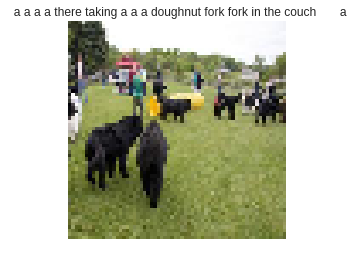

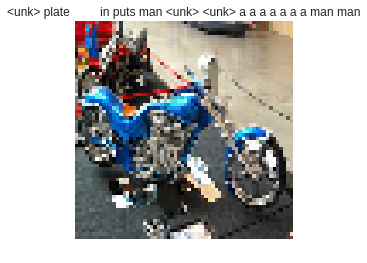

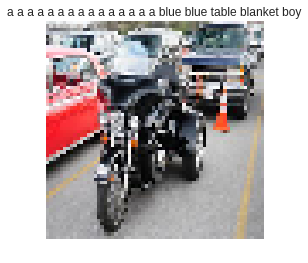

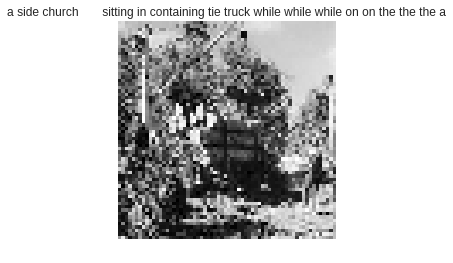

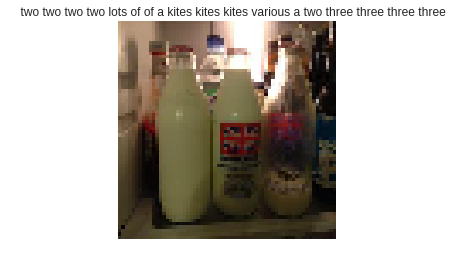

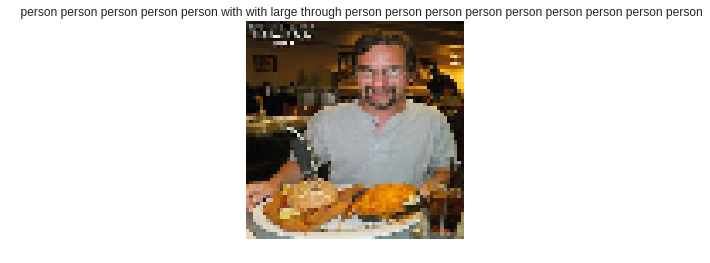

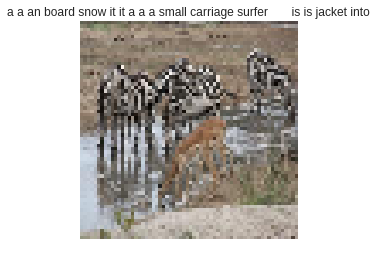

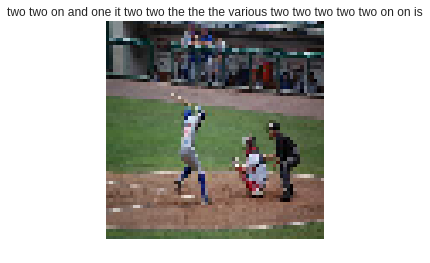

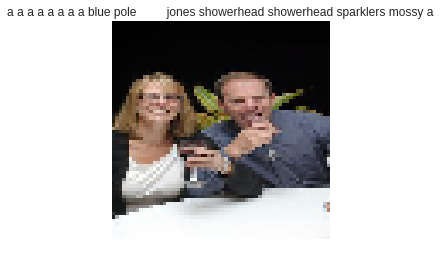

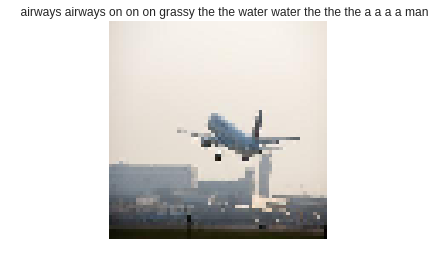

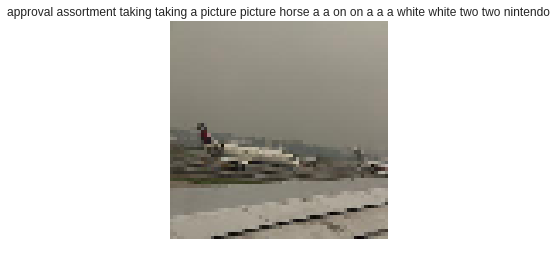

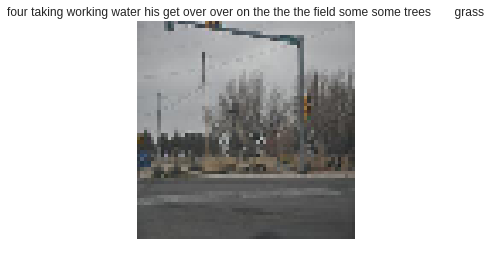

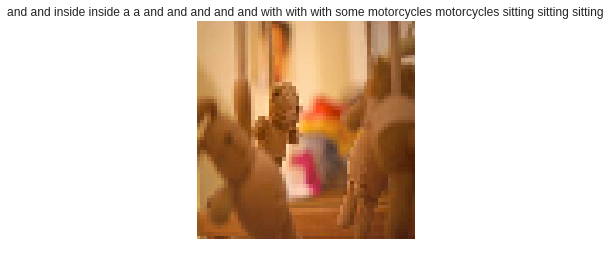

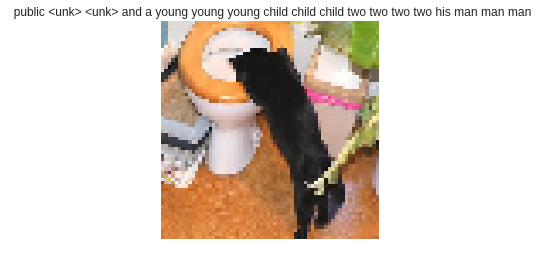

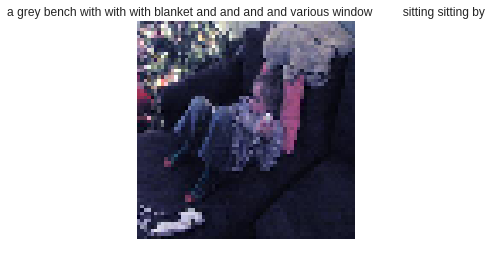

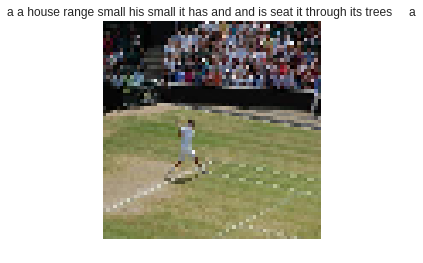

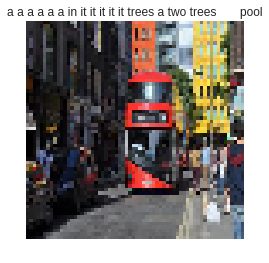

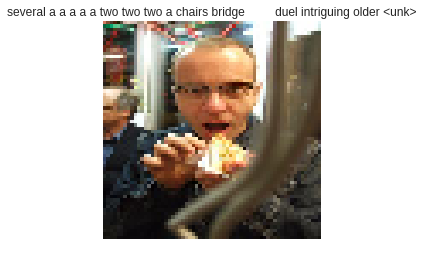

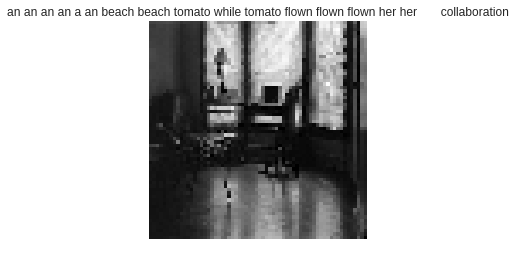

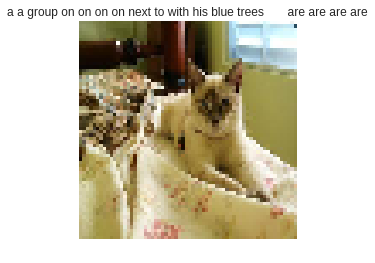

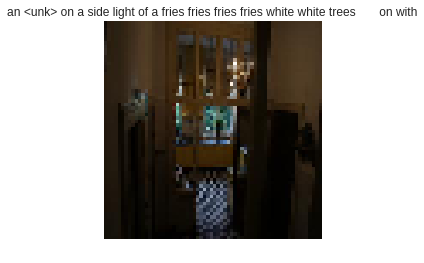

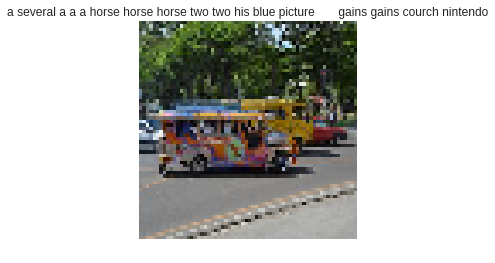

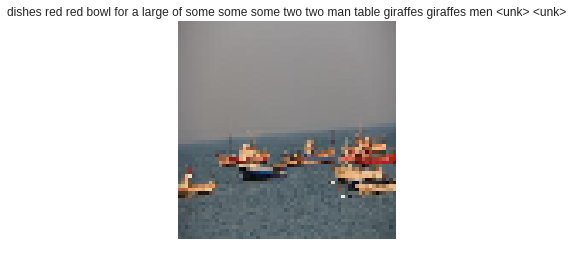

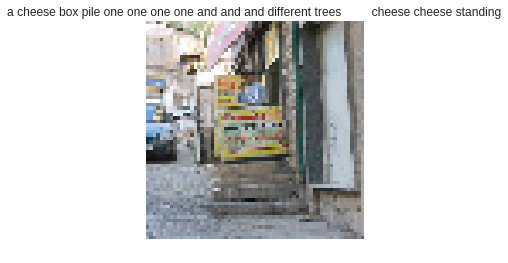

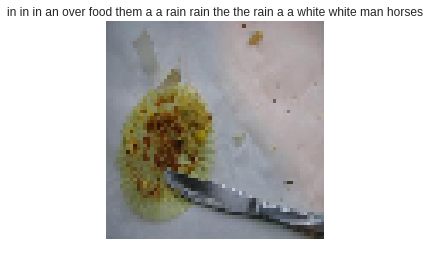

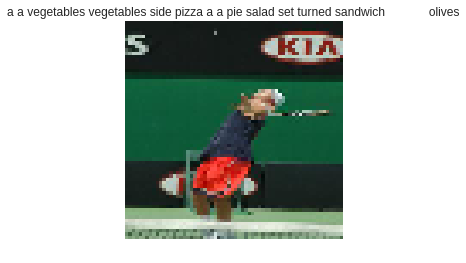

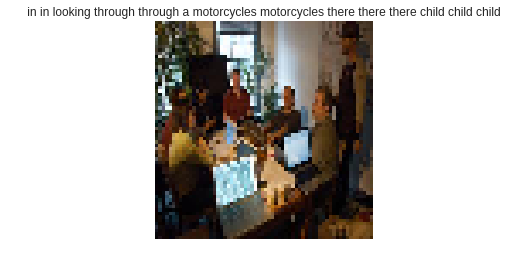

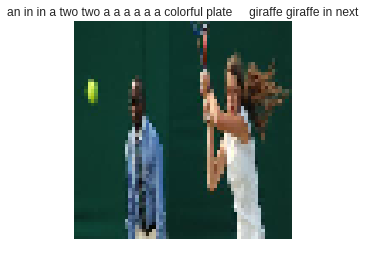

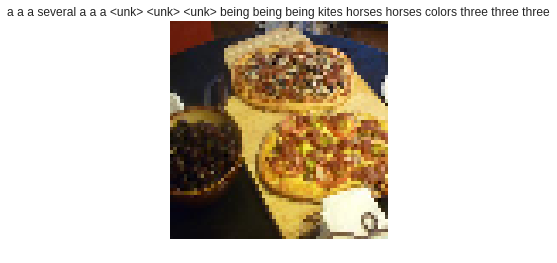

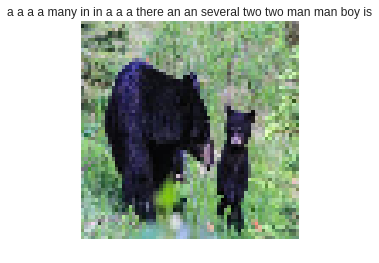

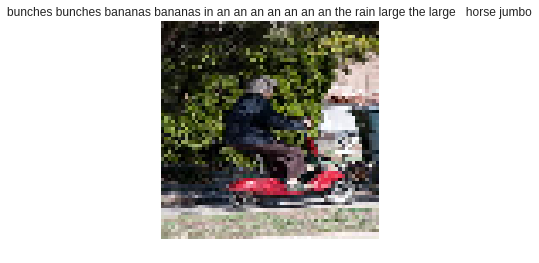

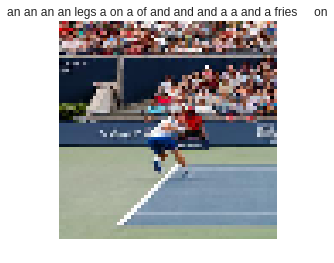

In [79]:
for i in range(0,32):
  plt.figure()
  plt.imshow(input_encoder[i])
  plt.axis('off')
  plt.title(' '.join(decode_sentence(out[i],sub_glove)))

### Text Illustration


In [0]:
model_input=layers.Input(shape=(20,),name="model_input") #Text 
out_text_encoder=text_encoder(model_input)  # Text -> Latent
out_image_decoder=image_decoder(out_text_encoder) # Latent -> Image

image_illustrator=keras.Model(inputs=model_input, outputs=out_image_decoder)

Text(0.5, 1.0, 'traffic sign on w <unk> st with photo of bicycle in the top              ')

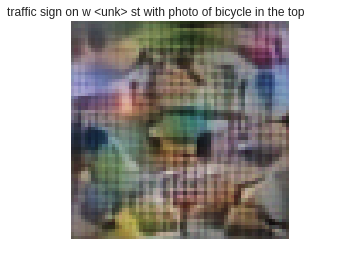

In [81]:
input_encoder,_=text_validation_sequence[1]
out=image_illustrator.predict(input_encoder)
#print(dec)

i=10
plt.figure()
plt.imshow(out[i])
plt.axis('off')
plt.title(' '.join(decode_sentence(input_encoder[i],sub_glove)))




Text(0.5, 1.0, 'a group of people gathered around a laptop computer                      ')

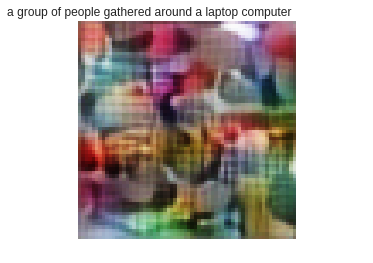

In [95]:
i=13
plt.figure()
plt.imshow(out[i])
plt.axis('off')
plt.title(' '.join(decode_sentence(input_encoder[i],sub_glove)))



## Viz


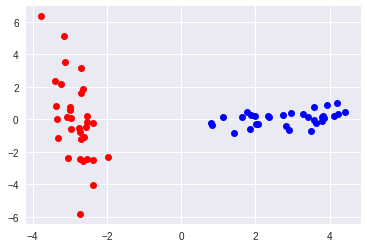

In [108]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


k=20
batch_i_x,_=img_training_sequence[k]
batch_t_x,_=text_training_sequence[k]

out_text_encoder=text_encoder.predict(batch_t_x)
out_img_encoder=image_encoder.predict(batch_i_x)


n=2
pca = PCA(n_components=n, svd_solver='full')
pca.fit( np.concatenate([out_text_encoder,out_img_encoder], axis=0))

out_text_encoder_pca=pca.transform(out_text_encoder)
out_img_encoder_pca=pca.transform(out_img_encoder)

if n==2 : 
  fig=plt.figure()
  plt.plot(out_img_encoder_pca[:,0],out_img_encoder_pca[:,1], 'ro')
  plt.plot(out_text_encoder_pca[:,0],out_text_encoder_pca[:,1], 'bo')
else :
  fig=plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(xs=out_text_encoder_pca[:,0], ys=out_text_encoder_pca[:,1], zs=out_text_encoder_pca[:,2])
  ax.scatter(xs=out_img_encoder_pca[:,0], ys=out_img_encoder_pca[:,1], zs=out_img_encoder_pca[:,2])